<a href="https://colab.research.google.com/github/rashidmeras/EVA_PHASE1/blob/master/EVA_S9_Assignment_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EVA Session9 Assignment 9: 

Objective:


1. Take the 6A Code, and show how it can be integrated with gradCAM. As proof of integration, test 4 images (remember the image ids or names) from your network and show the visualization.
2. Train your 6A model again, but this time add CutOut. Show the same 4 images again with gradCAM's result. 


In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(900) 
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D, Convolution2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras import regularizers

Using TensorFlow backend.


In [2]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 2s 0us/step


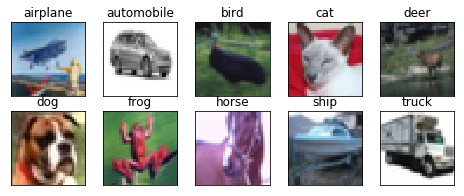

In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
# Copy the test features, used for gradCAM
test_features_copy = test_features

In [0]:
# Flatten 32x32x3 images to a 1024*3 vector for each image.
train_features = train_features.reshape(train_features.shape[0], 32, 32, 3)
test_features = test_features.reshape(test_features.shape[0], 32, 32, 3)

train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255

# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

##Image Normalization

In [8]:
batch_size = 128

# standardize images
def prep_standardize(train, test):
	# convert from integers to floats
	train_stan = train.astype('float32')
	test_stan  = test.astype('float32')
	# calculate statistics
	m = train_stan.mean()
	s = train_stan.std()
	# center datasets
	train_stan = (train_stan - m) / s
	test_stan  = (test_stan - m) / s
	# return normalized images
	return train_stan, test_stan

train_features, test_features = prep_standardize(train_features, test_features)

print('Train min=%.3f, max=%.3f' % (train_features.min(), train_features.max()))
print('Test min=%.3f, max=%.3f' % (test_features.min(), test_features.max()))

Train min=-1.882, max=2.093
Test min=-1.882, max=2.093


In [9]:
# Define the model
model = Sequential()

model.add(Conv2D(32,  kernel_size=(3, 3), use_bias=False, padding='same', name='Layer1',input_shape=(32, 32, 3))) 
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(Conv2D(64,  kernel_size=(3, 3), use_bias=False, padding='same', name='Layer2'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(Conv2D(64,  kernel_size=(3, 3), use_bias=False, name='Layer3'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(Conv2D(128, kernel_size=(3, 3), use_bias=False, name='Layer4'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(Conv2D(16,  kernel_size=(1, 1), use_bias=False, name='Layer5'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))

#Layer: Max-Pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64,  kernel_size=(3, 3), use_bias=False, padding='same', name='Layer6'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(Conv2D(64,  kernel_size=(3, 3), use_bias=False, name='Layer7'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(Conv2D(128, kernel_size=(3, 3), use_bias=False, name='Layer8'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(Conv2D(16,  kernel_size=(1, 1), use_bias=False, name='Layer9'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))

#Layer: Max-Pooling layer
model.add(MaxPooling2D(pool_size=(2, 2))) 

model.add(Conv2D(64,  kernel_size=(3, 3), use_bias=False, padding='same', name='Layer10'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(Conv2D(64,  kernel_size=(3, 3), use_bias=False, padding='same', name='Layer11'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(Conv2D(128, kernel_size=(3, 3), use_bias=False, name='Layer12'))
model.add(Activation('relu'))

model.add(Conv2D(num_classes, kernel_size=(3, 3), use_bias=False, name='Layer13'))

#Layer: Flatten & activation
model.add(Flatten())
model.add(Activation('softmax'))

#Print model summary
model.summary()

W0626 16:47:46.685119 140356438910848 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0626 16:47:46.722343 140356438910848 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0626 16:47:46.730676 140356438910848 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0626 16:47:46.767980 140356438910848 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0626 16:47:46.769039 1403564389

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Layer1 (Conv2D)              (None, 32, 32, 32)        864       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
Layer2 (Conv2D)              (None, 32, 32, 64)        18432     
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)        0         
__________

### Grad CAM integration

In [0]:
import keras.backend as K
import numpy as np
import cv2
from keras.preprocessing import image


def process_with_gradcam():

    test_images = [test_features_copy[0], test_features_copy[1], test_features_copy[2], test_features_copy[3]]

#     test_images = []
#     test_images.append(test_features_copy[100])

    processed_images = []

    c = 0
    for k in test_images:
      
      img = k
  
      img_t = np.expand_dims(img, axis=0)
      img_t = img_t / img_t.mean()  
  
      preds = model.predict(img_t)
      class_idx = np.argmax(preds[0])
      class_output = model.output[:, class_idx]
      last_conv_layer = model.get_layer("Layer12")  
  
      grads = K.gradients(class_output, last_conv_layer.output)[0]
      pooled_grads = K.mean(grads, axis=(0, 1, 2))
      iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
      pooled_grads_value, conv_layer_output_value = iterate([img_t])
  
      for i in range(32):
          conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
      heatmap = np.mean(conv_layer_output_value, axis=-1)
      heatmap = np.maximum(heatmap, 0)
      heatmap /= np.max(heatmap)
  
      img = k

      heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
      heatmap = np.uint8(255 * heatmap)
      heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  

      superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
  
      print ("Original")
      plt.imshow(test_features[c])
#     plt.imshow(img)
      plt.show()
      print ("Heatmap")
      plt.imshow(heatmap)
      plt.show()  
      print ("SuperImposed")
      plt.imshow(superimposed_img)
      plt.show()
      c += 1
  
      processed_images.append(img)
      processed_images.append(superimposed_img)
      processed_images.append(heatmap)


##Part 1 - Run Network without CutOff

W0626 16:47:51.287504 140356438910848 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0626 16:47:51.296752 140356438910848 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to 0.1.
 - 29s - loss: 0.2382 - acc: 0.9103 - val_loss: 0.2402 - val_acc: 0.9103

Epoch 00001: val_acc improved from -inf to 0.91026, saving model to best_new_model.h5
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to 0.1.
 - 24s - loss: 0.1814 - acc: 0.9288 - val_loss: 0.1771 - val_acc: 0.9316

Epoch 00002: val_acc improved from 0.91026 to 0.93158, saving model to best_new_model.h5
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to 0.1.
 - 24s - loss: 0.1524 - acc: 0.9400 - val_loss: 0.1462 - val_acc: 0.9439

Epoch 00003: val_acc improved from 0.93158 to 0.94386, saving model to best_new_model.h5
Epoch 4/10

Epoch 00004: LearningRateScheduler setting learning rate to 0.1.
 - 25s - loss: 0.1324 - acc: 0.9477 - val_loss: 0.1398 - val_acc: 0.9461

Epoch 00004: val_acc improved from 0.94386 to 0.94612, saving model to best_new_mo

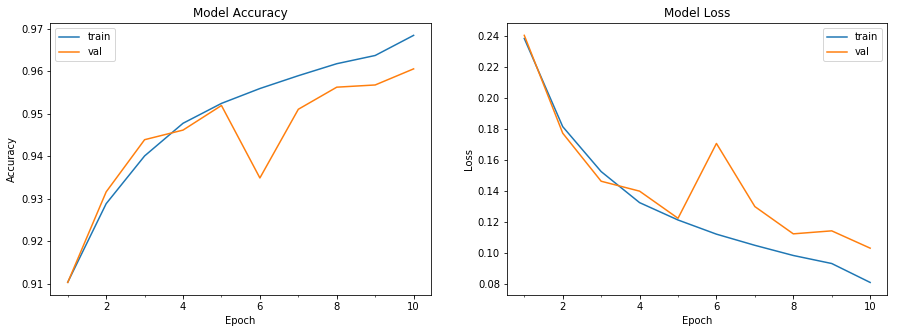

Accuracy on test data is: 78.71 



In [11]:
import math
import numpy as np
from keras.optimizers import Adam, SGD, rmsprop
from keras.callbacks import LearningRateScheduler

# learning rate schedule
def step_decay(epoch):
	initial_lrate = 0.1
	drop = 0.5
	epochs_drop = 10.0
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate

sgd = SGD(lr=0.0, momentum=0.9, decay=0.0, nesterov=False)
  
model.compile(optimizer= sgd,
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

save_mcp = ModelCheckpoint('best_new_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

# Train the model
start = time.time()

history = model.fit(train_features,       
                    train_labels,
                    batch_size=batch_size,
                    epochs=10,                  
                    validation_data=(test_features, test_labels),
                    callbacks=[save_mcp, LearningRateScheduler(step_decay, verbose=1)], 
                    verbose=2)


end = time.time()
print ("Model took %0.2f seconds to train \n"%(end - start))

# plot model history
plot_model_history(history)

# compute test accuracy
print ("Accuracy on test data is: %0.2f \n"%accuracy(test_features, test_labels, model))

Run Grad CAM

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
W0626 17:54:17.428633 140356438910848 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original


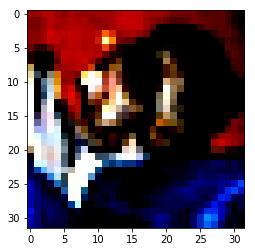

Heatmap


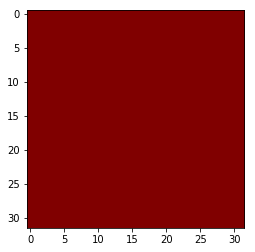

SuperImposed


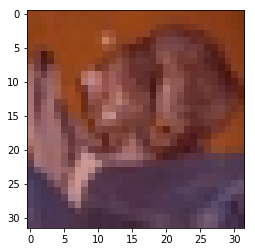

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
W0626 17:54:18.446780 140356438910848 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original


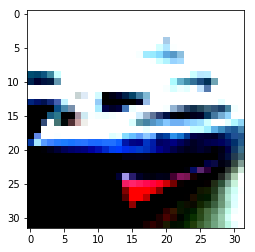

Heatmap


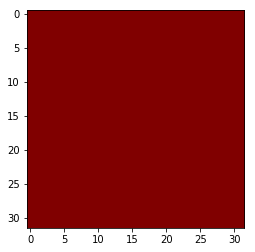

SuperImposed


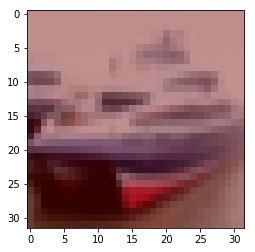

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
W0626 17:54:19.532659 140356438910848 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original


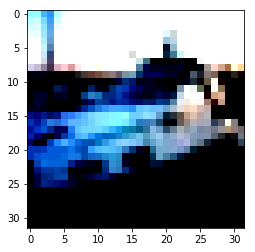

Heatmap


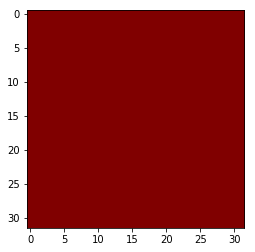

SuperImposed


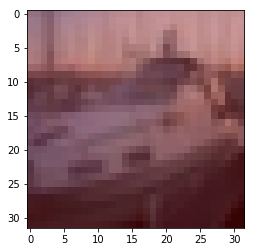

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
W0626 17:54:20.668462 140356438910848 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original


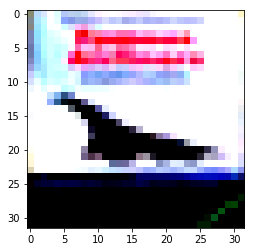

Heatmap


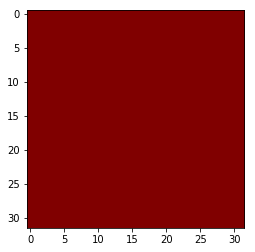

SuperImposed


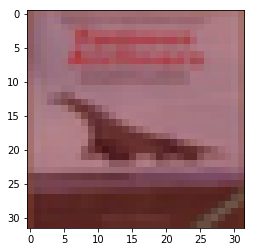

In [36]:
process_with_gradcam()

##Part 2 - Run Network with CutOff

Using real-time data augmentation.
Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to 0.1.
 - 28s - loss: 0.1385 - acc: 0.9462 - val_loss: 0.1122 - val_acc: 0.9570

Epoch 00001: val_acc improved from -inf to 0.95705, saving model to best_new_model.h5
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to 0.1.
 - 26s - loss: 0.1303 - acc: 0.9494 - val_loss: 0.1265 - val_acc: 0.9521

Epoch 00002: val_acc did not improve from 0.95705
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to 0.1.
 - 26s - loss: 0.1246 - acc: 0.9517 - val_loss: 0.1302 - val_acc: 0.9509

Epoch 00003: val_acc did not improve from 0.95705
Epoch 4/10

Epoch 00004: LearningRateScheduler setting learning rate to 0.1.
 - 26s - loss: 0.1211 - acc: 0.9526 - val_loss: 0.1073 - val_acc: 0.9582

Epoch 00004: val_acc improved from 0.95705 to 0.95819, saving model to best_new_model.h5
Epoch 5/10

Epoch 00005: LearningRateScheduler setting learning rate to 0.1.
 - 26s - 

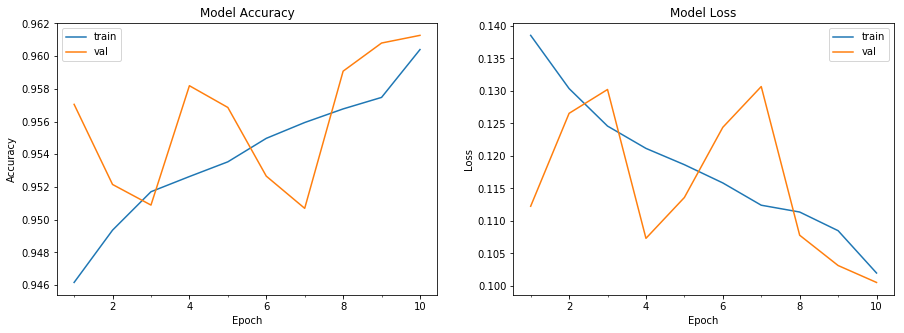

Accuracy on test data is: 78.84 



In [13]:
from keras.preprocessing.image import ImageDataGenerator
import math
import numpy as np
from keras.optimizers import Adam, SGD, rmsprop
from keras.callbacks import LearningRateScheduler

random_erasing = True
pixel_level = False

# Cut-out
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser
  
# learning rate schedule
def step_decay(epoch):
	initial_lrate = 0.1
	drop = 0.5
	epochs_drop = 10.0
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate

sgd = SGD(lr=0.0, momentum=0.9, decay=0.0, nesterov=False)
  
model.compile(optimizer= sgd,
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

save_mcp = ModelCheckpoint('best_new_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

# DA options: CutOff

print('Using real-time data augmentation.')

# This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=pixel_level))

datagen.fit(train_features)    
    
# Train the model
start = time.time()

# Fit the model on the batches generated by datagen.flow().
history = model.fit_generator(datagen.flow(train_features, train_labels, batch_size=batch_size),
          steps_per_epoch=train_features.shape[0] // batch_size,
          validation_data=(test_features, test_labels),
          epochs=10, 
          callbacks=[save_mcp, LearningRateScheduler(step_decay, verbose=1)],
          verbose=2)

end = time.time()
print ("Model took %0.2f seconds to train \n"%(end - start))

# plot model history
plot_model_history(history)

# compute test accuracy
print ("Accuracy on test data is: %0.2f \n"%accuracy(test_features, test_labels, model))

Run Grad CAM

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
W0626 17:54:27.346571 140356438910848 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original


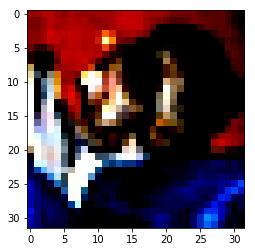

Heatmap


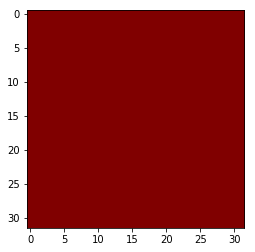

SuperImposed


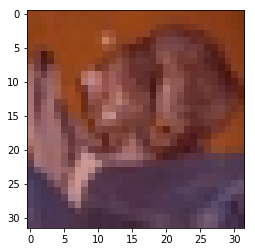

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
W0626 17:54:28.500149 140356438910848 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original


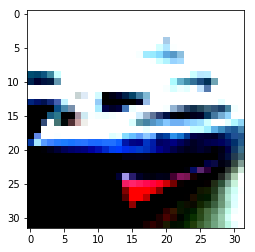

Heatmap


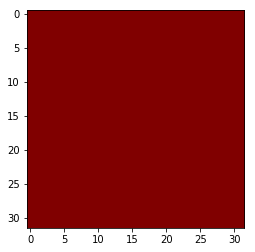

SuperImposed


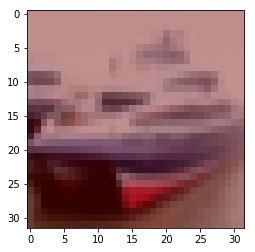

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
W0626 17:54:29.634339 140356438910848 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original


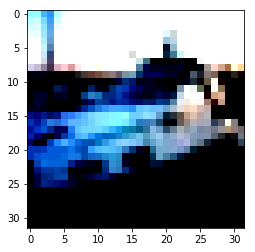

Heatmap


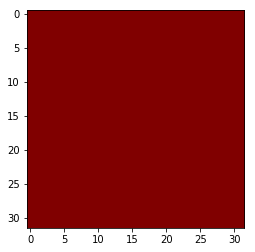

SuperImposed


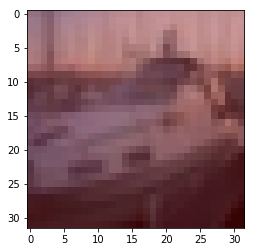

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
W0626 17:54:30.769897 140356438910848 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original


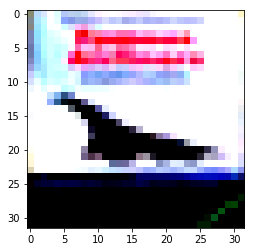

Heatmap


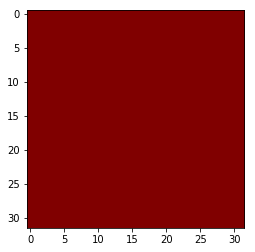

SuperImposed


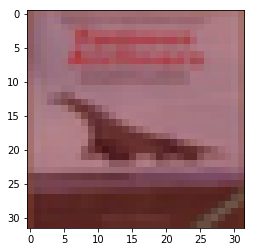

In [37]:
process_with_gradcam()

## Summary:

A trained network is successfully integrated with GradCAM and 4 images were visualized. The same network was retrained by adding a Data Augmantation method known as CutOff and the same 4 images were visualized.

Thank you!

